コンテスト概要
https://www.kaggle.com/c/ventilator-pressure-prediction

人工呼吸器をつないで人工肺に呼吸を促した際に、肺の内圧がどのような値になるのかを予測するコンテストです。人工呼吸器の機能としては以下の2点が主なようです。

１：肺に空気を送り込む（入力弁を開けて空気を入れる）

２：肺から空気を出す（出力弁を開けて空気を外に出す）

|

問題点と現状

利用する際には１と２のバランスが重要で入力弁をずっと開けていても肺がパンパンになりますし、出力弁を開けるだけでは空気が入ってきません。現状ではこのバランス調整は医療従事者が監視して行っているようです。

|

将来的なコンテストの役割

したがって１と２の具合から肺の内圧が予測できるようになれば、監視人員はいらなくなり現場がよりスムーズに機能することが期待されます。

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#各種インポート
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize, scale
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

In [22]:
# データロード
#教師データ
train_ori = pd.read_csv('/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/train.csv') 

#テストデータ
test_ori = pd.read_csv('/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/test.csv')

#提出形式の空データ
submission = pd.read_csv('/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/sample_submission.csv')

# データ観察

学習データについて

id - 1から始まるindex。１からtrain_ori.shape[0]までの値を取る

breath_id - 呼吸ごとの識別id。1回の呼吸で80個のデータが存在する（id = 81 になると breath_id = 2 になる）。

R - 人工肺への空気の入りにくさ、1秒に1Lの空気を入れるのにどれくらい圧をかける必要があるか[cmH2O/(L/sec)]。
例えば入り口がすごく細い肺は空気が入りづらい⇒R大。

C - 人工肺の膨らみやすさ[mL/cmH2O]。これが大きいと低い圧力でも肺が膨らむ。逆にこれが低いと肺は膨らみにくい。

time_step - 各呼吸に関して時間経過を表す。呼吸がリセットされればまた0からスタート

u_in - 空気が入る弁の開き具合。0-100の連続値で0なら閉じている。

u_out - 空気が出る弁の開閉。0か1をとる。0は閉じた状態。


u_in, u_outは操作できる値。RとCは肺によって決まる値だが、実務上は患者の疾患等によってある程度推定できるのかもしれない

In [ ]:
train_ori.head(83)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
78,79,1,20,50,2.655746,4.984683,1,6.540513
79,80,1,20,50,2.689766,4.987079,1,6.470211
80,81,2,20,20,0.000000,12.184338,0,6.048398
81,82,2,20,20,0.033998,13.980205,0,7.524743


RやCは肺ごとに固定されているように見えるし、そもそも連続値ではなさそう⇒カテゴリとして扱えそう

他の数値に関しては文章での説明通りに見える

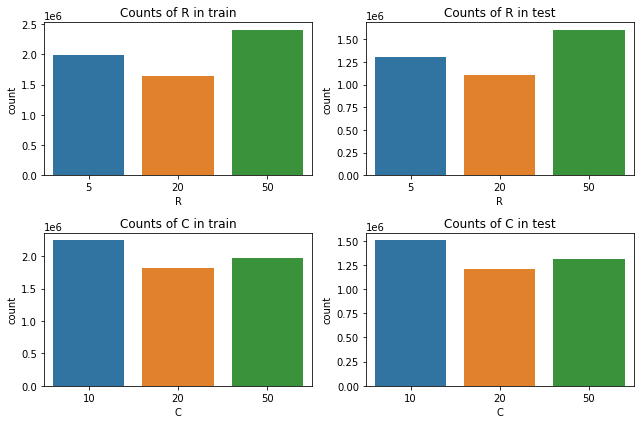

In [ ]:
fig, ax = plt.subplots(figsize = (9, 6))
plt.subplot(2, 2, 1)
sns.countplot(x='R', data=train_ori)
plt.title('Counts of R in train');
plt.subplot(2, 2, 2)
sns.countplot(x='R', data=test_ori)
plt.title('Counts of R in test');
plt.subplot(2, 2, 3)
sns.countplot(x='C', data=train_ori)
plt.title('Counts of C in train');
plt.subplot(2, 2, 4)
sns.countplot(x='C', data=test_ori)
plt.title('Counts of C in test');
plt.tight_layout()

実際に確認してみるとR,Cは三種類の値しかとらないことがわかった

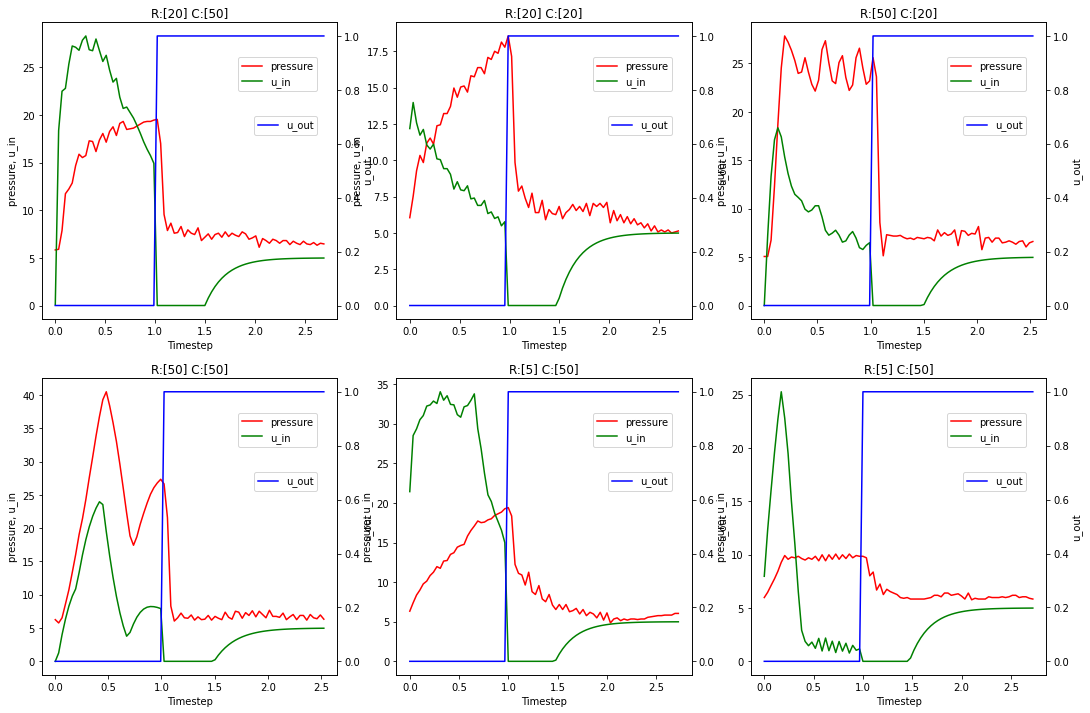

In [ ]:
fig = plt.figure(figsize = (18, 12))
for i in range(6):
    ax1=plt.subplot(2,3,i+1)
    breath_1 = train_ori.loc[train_ori['breath_id'] == i+1]
    ax2 = ax1.twinx()

    ax1.plot(breath_1['time_step'], breath_1['pressure'], 'r-', label='pressure')
    ax1.plot(breath_1['time_step'], breath_1['u_in'], 'g-', label='u_in')
    ax2.plot(breath_1['time_step'], breath_1['u_out'], 'b-', label='u_out')

    ax1.set_xlabel('Timestep')

    ax1.legend(bbox_to_anchor=(0.95, 0.9), loc="upper right")
    ax1.set_ylabel("pressure, u_in")
    ax2.legend(bbox_to_anchor=(0.95, 0.7), loc="upper right")
    ax2.set_ylabel("u_out")
    ax1.set_title(f"R:{breath_1['R'].unique()} C:{breath_1['C'].unique()}")
plt.show()

RとCが異なる6種類の組み合わせについてプロットした。

組み合わせによって振る舞いが異なるように見える

Text(0.5, 1.0, 'R:[50] C:[50]')

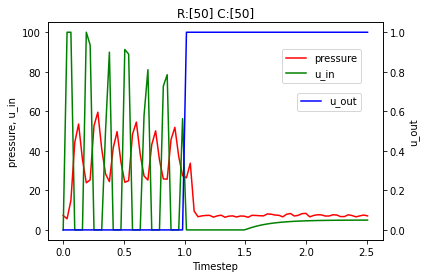

In [ ]:
ax1=plt.subplot(1,1,1)
breath_1 = train_ori.loc[train_ori['breath_id'] == 928]
ax2 = ax1.twinx()

ax1.plot(breath_1['time_step'], breath_1['pressure'], 'r-', label='pressure')
ax1.plot(breath_1['time_step'], breath_1['u_in'], 'g-', label='u_in')
ax2.plot(breath_1['time_step'], breath_1['u_out'], 'b-', label='u_out')

ax1.set_xlabel('Timestep')

ax1.legend(bbox_to_anchor=(0.95, 0.9), loc="upper right")
ax1.set_ylabel("pressure, u_in")
ax2.legend(bbox_to_anchor=(0.95, 0.7), loc="upper right")
ax2.set_ylabel("u_out")
ax1.set_title(f"R:{breath_1['R'].unique()} C:{breath_1['C'].unique()}")

もう少しpressureとu_inの関係を見ていく

例えばbreath_id=928のデータについてみてみる

u_inとpressureの山が若干ずれていることがわかる

確かに先ほどのデータを見てもu_inとpressureの間にはずれが見える。これは良い特徴量になりそう

# 特徴量エンジニアリング

In [11]:
def add_features(df):
    # 他の参加者たちがやっていたが物理的な意味は把握できなかった。しかしスコアが向上したのは事実なので追加。
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()

    #ほかのユーザーが「この特徴量を加えるとスコア」が上がると言っていたため追加。入力弁を開けた程度の累積和のようなもの
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    # pressureとu_inの山のずれを考慮した特徴量
    # u_inとu_outは構造上密接なつながりがあるのでこちらにも適用
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)

    #上記の1データずらしだけではなく下記2～4データずらしを加えることで網羅的にできると考えた
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    
    df = df.fillna(0)
    
    # 過去の呼吸からの増分
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']

    # 各breath_idに現れるu_in, u_outの最大値
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')

    # 各breath_idにおける最大値、平均値との差
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    # u_outは扱いずらいが以下のようにしてどうにか特徴づけた。他の参加者たちもやっていたため見当外れではないはず
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']

    #RとCに関してone-hot化した
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

train = add_features(train_ori)
test = add_features(test_ori)


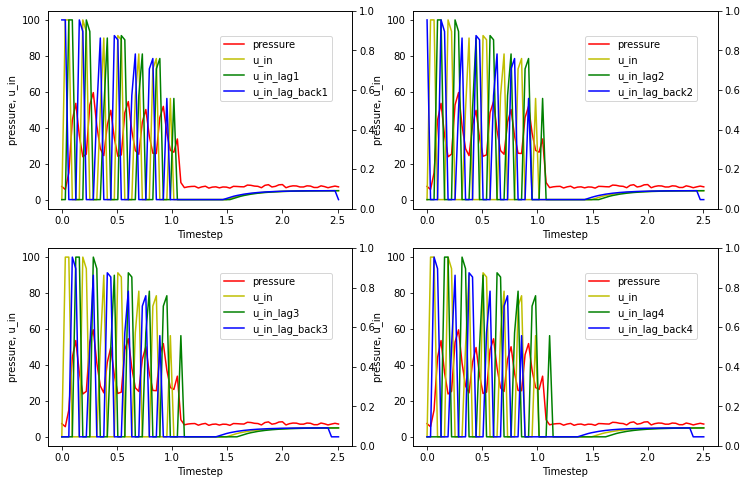

In [ ]:
a=train.where(train["breath_id"]==928)

fig = plt.figure(figsize = (12, 8))
for i in range(1,5):
    ax1=plt.subplot(2,2,i)
    ax2 = ax1.twinx()

    ax1.plot(a['time_step'], a['pressure'], 'r-', label='pressure')
    ax1.plot(a['time_step'], a['u_in'], 'y-', label='u_in')
    ax1.plot(a['time_step'], a['u_in_lag{}'.format(i)], 'g-', label='u_in_lag{}'.format(i))
    ax1.plot(a['time_step'], a['u_in_lag_back{}'.format(i)], 'b-', label='u_in_lag_back{}'.format(i))

    ax1.set_xlabel('Timestep')

    ax1.legend(bbox_to_anchor=(0.95, 0.9), loc="upper right")
    ax1.set_ylabel("pressure, u_in")
    #ax1.set_title(f"R:{breath_1['R'].unique()} C:{breath_1['C'].unique()}")
plt.show()

lagの特徴量は図示すると上記のようになった


In [ ]:
train

,id,breath_id,time_step,u_in,u_out,pressure,area,u_in_cumsum,u_in_lag1,u_out_lag1,u_in_lag_back1,u_out_lag_back1,u_in_lag2,u_out_lag2,u_in_lag_back2,u_out_lag_back2,u_in_lag3,u_out_lag3,u_in_lag_back3,u_out_lag_back3,u_in_lag4,u_out_lag4,u_in_lag_back4,u_out_lag_back4,u_in_diff1,u_out_diff1,u_in_diff2,u_out_diff2,u_in_diff3,u_out_diff3,u_in_diff4,u_out_diff4,breath_id__u_in__max,breath_id__u_out__max,breath_id__u_in__diffmax,breath_id__u_in__diffmean,cross,cross2,R_20,R_5,R_50,C_10,C_20,C_50,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50
0,1,1,0.000000,0.083334,0,5.837492,0.000000,0.083334,0.000000,0.0,18.383041,0.0,0.000000,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,25.355850,0.0,0.083334,0.0,0.083334,0.0,0.083334,0.0,0.083334,0.0,28.313036,1,28.229702,10.062673,0.000000,0.000000,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,2,1,0.033652,18.383041,0,5.907794,0.618632,18.466375,0.083334,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,25.355850,0.0,0.000000,0.0,27.259866,0.0,18.299707,0.0,18.383041,0.0,18.383041,0.0,18.383041,0.0,28.313036,1,9.929994,-8.237035,0.000000,0.000000,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,3,1,0.067514,22.509278,0,7.876254,2.138333,40.975653,18.383041,0.0,22.808822,0.0,0.083334,0.0,25.355850,0.0,0.000000,0.0,27.259866,0.0,0.000000,0.0,27.127486,0.0,4.126236,0.0,22.425944,0.0,22.509278,0.0,22.509278,0.0,28.313036,1,5.803758,-12.363271,0.000000,0.000000,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,4,1,0.101542,22.808822,0,11.742872,4.454391,63.784476,22.509278,0.0,25.355850,0.0,18.383041,0.0,27.259866,0.0,0.083334,0.0,27.127486,0.0,0.000000,0.0,26.807732,0.0,0.299544,0.0,4.425781,0.0,22.725488,0.0,22.808822,0.0,28.313036,1,5.504214,-12.662816,0.000000,0.000000,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,5,1,0.135756,25.355850,0,12.234987,7.896588,89.140326,22.808822,0.0,27.259866,0.0,22.509278,0.0,27.127486,0.0,18.383041,0.0,26.807732,0.0,0.083334,0.0,27.864715,0.0,2.547028,0.0,2.846573,0.0,6.972809,0.0,25.272516,0.0,28.313036,1,2.957185,-15.209844,0.000000,0.000000,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,2.504603,1.489714,1,3.869032,270.089574,387.109297,1.420711,1.0,1.488497,1.0,1.353205,1.0,1.558978,1.0,1.357586,1.0,1.272663,1.0,1.362261,1.0,1.482739,1.0,0.069002,0.0,0.136509,0.0,0.132127,0.0,0.127452,0.0,25.504196,1,24.014482,3.421689,1.489714,2.504603,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
6035996,6035997,125749,2.537961,1.488497,1,3.869032,273.867320,388.597794,1.489714,1.0,1.558978,1.0,1.420711,1.0,1.272663,1.0,1.353205,1.0,1.482739,1.0,1.357586,1.0,0.000000,0.0,-0.001217,0.0,0.067785,0.0,0.135292,0.0,0.130910,0.0,25.504196,1,24.015699,3.422905,1.488497,2.537961,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
6035997,6035998,125749,2.571408,1.558978,1,3.798729,277.876088,390.156772,1.488497,1.0,1.272663,1.0,1.489714,1.0,1.482739,1.0,1.420711,1.0,0.000000,0.0,1.353205,1.0,0.000000,0.0,0.070481,0.0,0.069264,0.0,0.138266,0.0,0.205773,0.0,25.504196,1,23.945218,3.352424,1.558978,2.571408,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
6035998,6035999,125749,2.604744,1.272663,1,4.079938,281.191050,391.429435,1.558978,1.0,1.482739,1.0,1.488497,1.0,0.000000,0.0,1.489714,1.0,0.000000,0.0,1.420711,1.0,0.000000,0.0,-0.286315,0.0,-0.215834,0.0,-0.217050,0.0,-0.148048,0.0,25.504196,1,24.231532,3.638739,1.272663,2.604744,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
test

,id,breath_id,time_step,u_in,u_out,area,u_in_cumsum,u_in_lag1,u_out_lag1,u_in_lag_back1,u_out_lag_back1,u_in_lag2,u_out_lag2,u_in_lag_back2,u_out_lag_back2,u_in_lag3,u_out_lag3,u_in_lag_back3,u_out_lag_back3,u_in_lag4,u_out_lag4,u_in_lag_back4,u_out_lag_back4,u_in_diff1,u_out_diff1,u_in_diff2,u_out_diff2,u_in_diff3,u_out_diff3,u_in_diff4,u_out_diff4,breath_id__u_in__max,breath_id__u_out__max,breath_id__u_in__diffmax,breath_id__u_in__diffmean,cross,cross2,R_20,R_5,R_50,C_10,C_20,C_50,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50
0,1,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0,7.515046,0.0,0.000000,0.0,14.651675,0.0,0.000000,0.0,21.230610,0.0,0.000000,0.0,26.320956,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,37.542219,1,37.542219,9.327338,0.000000,0.000000,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,2,0,0.031904,7.515046,0,0.239758,7.515046,0.000000,0.0,14.651675,0.0,0.000000,0.0,21.230610,0.0,0.000000,0.0,26.320956,0.0,0.000000,0.0,30.486938,0.0,7.515046,0.0,7.515046,0.0,7.515046,0.0,7.515046,0.0,37.542219,1,30.027173,1.812292,0.000000,0.000000,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
2,3,0,0.063827,14.651675,0,1.174935,22.166721,7.515046,0.0,21.230610,0.0,0.000000,0.0,26.320956,0.0,0.000000,0.0,30.486938,0.0,0.000000,0.0,33.545950,0.0,7.136630,0.0,14.651675,0.0,14.651675,0.0,14.651675,0.0,37.542219,1,22.890543,-5.324338,0.000000,0.000000,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
3,4,0,0.095751,21.230610,0,3.207788,43.397331,14.651675,0.0,26.320956,0.0,7.515046,0.0,30.486938,0.0,0.000000,0.0,33.545950,0.0,0.000000,0.0,35.717600,0.0,6.578935,0.0,13.715564,0.0,21.230610,0.0,21.230610,0.0,37.542219,1,16.311609,-11.903272,0.000000,0.000000,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
4,5,0,0.127644,26.320956,0,6.567489,69.718287,21.230610,0.0,30.486938,0.0,14.651675,0.0,33.545950,0.0,7.515046,0.0,35.717600,0.0,0.000000,0.0,36.971061,0.0,5.090346,0.0,11.669281,0.0,18.805911,0.0,26.320956,0.0,37.542219,1,11.221263,-16.993619,0.000000,0.000000,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023995,4023996,125748,2.530117,4.971245,1,270.095487,194.714841,4.965959,1.0,4.975709,1.0,4.959653,1.0,4.979468,1.0,4.952134,1.0,4.982648,1.0,4.943394,1.0,4.985373,1.0,0.005286,0.0,0.011593,0.0,0.019111,0.0,0.027852,0.0,35.151391,1,30.180146,-2.288270,4.971245,2.530117,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4023996,4023997,125748,2.563853,4.975709,1,282.852472,199.690549,4.971245,1.0,4.979468,1.0,4.965959,1.0,4.982648,1.0,4.959653,1.0,4.985373,1.0,4.952134,1.0,0.000000,0.0,0.004463,0.0,0.009750,0.0,0.016056,0.0,0.023574,0.0,35.151391,1,30.175682,-2.292733,4.975709,2.563853,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4023997,4023998,125748,2.597475,4.979468,1,295.786514,204.670017,4.975709,1.0,4.982648,1.0,4.971245,1.0,4.985373,1.0,4.965959,1.0,0.000000,0.0,4.959653,1.0,0.000000,0.0,0.003759,0.0,0.008222,0.0,0.013508,0.0,0.019815,0.0,35.151391,1,30.171924,-2.296492,4.979468,2.597475,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4023998,4023999,125748,2.631134,4.982648,1,308.896526,209.652665,4.979468,1.0,4.985373,1.0,4.975709,1.0,0.000000,0.0,4.971245,1.0,0.000000,0.0,4.965959,1.0,0.000000,0.0,0.003180,0.0,0.006939,0.0,0.011402,0.0,0.016689,0.0,35.151391,1,30.168743,-2.299672,4.982648,2.631134,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [12]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['id',  'pressure', 'breath_id'], axis=1, inplace=True)
test = test.drop(['id', 'breath_id'], axis=1)

RS = RobustScaler()

train = RS.fit_transform(train)
test = RS.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

LSTMに組み込めるように次元を変更

# LSTMモデル

In [ ]:
EPOCH = 300
BATCH_SIZE = 512
FOLD=10

# メモリが不足するので各FOLDごとに毎回モデルを保存した。visitは保存したFOLDのリスト
visit=[0,1,2,3,4,5,6,7,8]

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

with tpu_strategy.scope():
    kf = KFold(n_splits=FOLD, shuffle=True, random_state=2021)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        if fold in visit:
          continue
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        model = keras.models.Sequential([
            keras.layers.Input(shape=train.shape[-2:]),
            keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
            keras.layers.Dense(100, activation='selu'),
            keras.layers.Dense(1),
        ])
        model.compile(optimizer="adam", loss="mae")

        model.summary()

        scheduler = ExponentialDecay(1e-4, 400*((len(train)*0.8)/BATCH_SIZE), 1e-5)
        lr = LearningRateScheduler(scheduler, verbose=1)

        es = EarlyStopping(monitor="val_loss", patience=15, verbose=1, mode="min", restore_best_weights=True)

        model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr,es])
        model.save(f'/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD{FOLD}/model2_Fold{fold+1}.h5')
        

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.108.245.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.108.245.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


--------------- > Fold 1 < ---------------
--------------- > Fold 2 < ---------------
--------------- > Fold 3 < ---------------
--------------- > Fold 4 < ---------------
--------------- > Fold 5 < ---------------
--------------- > Fold 6 < ---------------
--------------- > Fold 7 < ---------------
--------------- > Fold 8 < ---------------
--------------- > Fold 9 < ---------------
--------------- > Fold 10 < ---------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 80, 2048)         8806400   
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 80, 1024)         10489856  
 onal)                                                           
                                                                 
 bidirectional_14 (

モデルのロード、予測

In [31]:
models_dir = "/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD10/"

test_preds=[]

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

with tpu_strategy.scope():
    for model_name in glob.glob(models_dir + '/*.h5'):
        print(model_name)
        model = tf.keras.models.load_model(model_name)
        a=model.predict(test)
        test_preds.append(a.squeeze().reshape(-1, 1).squeeze())


# 今回のコンテストでは評価がMAEなので予測の平均値ではなく中央値を使う方が良い
submission["pressure"] = np.median(np.vstack(test_preds),axis=0)
    

# 他の参加者から得た情報でpressureの構成に関するものがあった
unique_pressures = train_ori["pressure"].unique()
sorted_pressures = np.sort(unique_pressures)

total_pressures_len = len(sorted_pressures)
print("実はpressureは連続値ではなく、{}種類の数値で構成されている".format(total_pressures_len))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.91.11.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.91.11.122:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD10/model2_Fold1.h5
/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD10/model2_Fold3.h5
/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD10/model2_Fold2.h5
/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD10/model2_Fold4.h5
/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD10/model2_Fold5.h5
/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD10/model2_Fold6.h5
/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD10/model2_Fold8.h5
/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD10/model2_Fold7.h5
/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD10/model2_Fold9.h5
/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD10/model2_Fold10.h5
実はpressureは連続値ではなく、950種類の数値で構成されている


In [32]:
submission

,id,pressure
0,1,7.655351
1,2,9.505722
2,3,11.755802
3,4,13.469335
4,5,14.549633
...,...,...
4023995,4023996,6.165838
4023996,4023997,6.299832
4023997,4023998,6.157623
4023998,4023999,6.201804


In [33]:
#上記を参考に予測した値を950種類の離散値に丸め込む
def find_nearest(prediction):
    insert_idx = np.searchsorted(sorted_pressures, prediction)
    if insert_idx == total_pressures_len:
        # 離散値の最大値より大きな値を予測したら、離散値の最大を返す
        return sorted_pressures[-1]*1 + prediction*0
    elif insert_idx == 0:
        # 最小値についても同様
        return sorted_pressures[0]*1 + prediction*0
    lower_val = sorted_pressures[insert_idx - 1]
    upper_val = sorted_pressures[insert_idx]
    return lower_val if abs(lower_val - prediction) < abs(upper_val - prediction) else upper_val

submission["pressure"] = submission["pressure"].apply(find_nearest)
submission.to_csv('/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2_fold10.csv', index=False)

In [34]:
submission

,id,pressure
0,1,7.665347
1,2,9.493203
2,3,11.742872
3,4,13.500426
4,5,14.554958
...,...,...
4023995,4023996,6.189002
4023996,4023997,6.329607
4023997,4023998,6.189002
4023998,4023999,6.189002


予測値の様子

Text(0.5, 1.0, 'Our Prediction')

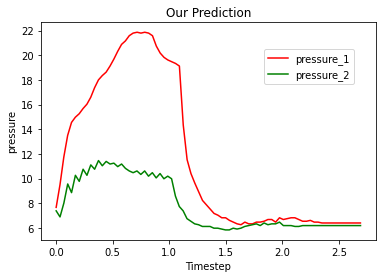

In [35]:
ax1=plt.subplot(1,1,1)
breath_1 = submission.loc[submission['id'] <= 80]
time1    = train_ori.loc[train_ori['id'] <= 80]
breath_2 = submission.loc[submission['id'] >= 81]
breath_2 = breath_2.loc[breath_2['id'] <= 160]
time2    = train_ori.loc[train_ori['id'] >= 81]
time2    = time2.loc[time2['id'] <=160]

ax1.plot(time1['time_step'], breath_1['pressure'], 'r-', label='pressure_1')
ax1.plot(time2['time_step'], breath_2['pressure'], 'g-', label='pressure_2')

ax1.set_xlabel('Timestep')

ax1.legend(bbox_to_anchor=(0.95, 0.9), loc="upper right")
ax1.set_ylabel("pressure")

ax1.set_title("Our Prediction")